In [ ]:
import torch
import torch.nn.functional as F
from torch import autograd, nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import pandas as pd
from skimage import io
import time
from PIL import Image
import math
from torch.utils.data import Dataset, DataLoader
import copy
# input 3*64*64
NUMCLASSES = 10
BATCHSIZE = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

Tesla V100-SXM2-16GB


In [ ]:
# Use torch ImageFolder
train_transform = transforms.Compose([
        # transforms.RandomResizedCrop(100),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(0, 360),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

data_transform = transforms.Compose([
        # transforms.RandomResizedCrop(100),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        
    ])

In [ ]:
train_dataset = datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCHSIZE, shuffle=True, num_workers=2)

test_dataset = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=data_transform)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCHSIZE, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
def show_cifar10(num):
  for i in range(num):
    for j in range(num):
      plt.subplot(num, num, i*num+j+1)
      plt.axis('off')
      plt.set_cmap('hot')
      plt.subplots_adjust(hspace = .005, wspace=.005)
      plt.imshow(train_dataset[i*num+j][0].permute(1,2,0), interpolation='nearest')

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channel, out_channel, stride=1):
      super().__init__()
      self.left = nn.Sequential(
          nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride, padding=1, bias=False),
          nn.BatchNorm2d(out_channel),
          nn.ReLU(inplace=True),
          nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1, bias=False),
          nn.BatchNorm2d(out_channel)
      )
      self.shortcut = nn.Sequential()
      if stride != 1 or in_channel != out_channel:
          self.shortcut = nn.Sequential(
              nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride, bias=False),
              nn.BatchNorm2d(out_channel)
          )

  def forward(self, x):
      out = self.left(x)
      out += self.shortcut(x)
      out = F.relu(out)
      return out

class ConvBlock(nn.Module):
  def __init__(self, in_channel, kernel_size, filters, stride):
    super().__init__()
    f1, f2, f3 = filters
    self.layer = nn.Sequential(
        nn.Conv2d(in_channel, f1, kernel_size=1, stride=stride, padding=0, bias=False),
        nn.BatchNorm2d(f1),
        nn.ReLU(),
        nn.Conv2d(f1, f2, kernel_size=kernel_size, stride=1, padding=True, bias=False),
        nn.BatchNorm2d(f2),
        nn.ReLU(),
        nn.Conv2d(f2, f3, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(f3),
        nn.ReLU()
    )
    self.shortcut = nn.Conv2d(in_channel, f3, kernel_size=1, stride=stride, padding=0, bias=False)
    self.batchnorm2d = nn.BatchNorm2d(f3)
    self.relu = nn.ReLU()
  def forward(self, x):
    out = self.layer(x)
    out += self.batchnorm2d(self.shortcut(x))
    out = self.relu(out)
    return out


class IndentityBlock(nn.Module):
  def __init__(self, in_channel, kernel_size, filters):
    super(IndentityBlock,self).__init__()
    f1, f2, f3 = filters
    self.layer = nn.Sequential(
        nn.Conv2d(in_channel, f1 , kernel_size=1,stride=1, padding=0, bias=False),
        nn.BatchNorm2d(f1),
        nn.ReLU(),
        nn.Conv2d(f1, f2, kernel_size=kernel_size, stride=1, padding=True, bias=False),
        nn.BatchNorm2d(f2),
        nn.ReLU(),
        nn.Conv2d(f2, f3 ,kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(f3),
    )
    self.relu = nn.ReLU(True)
    self.shorcut = nn.Sequential()
  def forward(self, x):
    out = self.layer(x)
    out += self.shorcut(x)
    out = self.relu(out)
    del x
    return out

In [ ]:
class ResNet18(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super().__init__()
        self.in_channel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        ) # 3*32*32->64*32*32
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1) # 64**32*32->64*32*32
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2) # 128*16*16-->128*16*16-
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2) # 256*8*8->256*8*8
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2) # 512*4*4->512*4*4
        self.fc = nn.Linear(512, num_classes)
        
    def make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.in_channel, out_channels, stride))
            self.in_channel = out_channels
        return nn.Sequential(*layers)
 
    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [ ]:

# planes == channels

class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat([out,x], 1)
        return out


class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = F.avg_pool2d(out, 2)
        return out


# block -> Bottleneck
class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)

        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate

        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes, num_classes)

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out = F.avg_pool2d(F.relu(self.bn(out)), 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def DenseNet121():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=32)

def DenseNet169():
    return DenseNet(Bottleneck, [6,12,32,32], growth_rate=32)

def DenseNet201():
    return DenseNet(Bottleneck, [6,12,48,32], growth_rate=32)

def DenseNet161():
    return DenseNet(Bottleneck, [6,12,36,24], growth_rate=48)

In [ ]:
def evaluate(model, data_loader, criterion):
  avg_loss = 0.0
  total = 0.
  accuracy = 0.
  test_loss = []
  model.eval()
  for batch_num, (feats, labels) in enumerate(data_loader):
      feats, labels = feats.to(device), labels.to(device)
      outputs = model(feats)
      
      prob = F.softmax(outputs.detach(), dim=1)
      
      _, pred_labels = torch.max(prob, 1)
      pred_labels = pred_labels.view(-1)

      loss = criterion(outputs, labels.long())
      
      accuracy += torch.sum(torch.eq(pred_labels, labels)).item()
      total += len(labels)
      test_loss.extend([loss.item()]*feats.size()[0])

      torch.cuda.empty_cache()
      del outputs
      del feats
      del labels
      del pred_labels
      del prob

  return np.mean(test_loss), accuracy/total

In [ ]:
criterion = nn.CrossEntropyLoss()

model = ResNet18(ResidualBlock).to(device)

# model = DenseNet121().to(device)
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)



def load_DenseNet121():
  !cp '/content/drive/My Drive/Colab Notebooks/adversarial/Model_19' '/content/'
  checkpoint = torch.load('Model_19')
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


In [ ]:
def train(model, train_loader, optimizer, criterion,  epochs):
  model.train()
  start_time = time.time()

  for epoch in range(epochs):
    total = 0.0
    train_acc = 0.0
    train_loss = []
    total_labels = []

    model.train()
    for batch_num, (feats, labels) in enumerate(train_loader):
      feats, labels = feats.to(device), labels.to(device)
      optimizer.zero_grad()
      with torch.cuda.amp.autocast():
        outputs = model(feats)
        loss = criterion(outputs, labels.long())
      loss.backward()
      optimizer.step()

      prob = F.softmax(outputs.detach(), dim=1)

      _, pred_labels = torch.max(prob, 1)
      pred_labels = pred_labels.view(-1)
      train_acc += torch.sum(torch.eq(pred_labels, labels)).item()    
      
      total += len(labels)
      train_loss.extend([loss.item()]*feats.size()[0])
      torch.cuda.empty_cache()

      del loss
      del feats
      del labels
      del pred_labels
      del outputs
      del prob

    scheduler.step()

    torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                #'scheduler_state_dict' : scheduler.state_dict(),
    }, "Model_"+str(epoch))
    val_loss, val_acc = evaluate(model, test_loader, criterion)
    print('epoch: %d\t'%(epoch+1),  'time: %d m: %d s '% divmod(time.time() - start_time, 60))
    start_time = time.time()
    print('train_loss: %.5f\ttrain_acc: %.5f' %(np.mean(train_loss), train_acc/total))
    print('val_loss: %.5f\tval_acc: %.5f'% (val_loss, val_acc))
    print('*'*60)

In [ ]:
train(model, train_loader, optimizer, criterion,  20)

epoch: 1	 time: 0 m: 34 s 
train_loss: 1.26788	train_acc: 0.54436
val_loss: 1.01322	val_acc: 0.65420
************************************************************
epoch: 2	 time: 0 m: 33 s 
train_loss: 0.73985	train_acc: 0.74196
val_loss: 0.70058	val_acc: 0.75500
************************************************************
epoch: 3	 time: 0 m: 33 s 
train_loss: 0.57337	train_acc: 0.80036
val_loss: 0.70656	val_acc: 0.76040
************************************************************
epoch: 4	 time: 0 m: 33 s 
train_loss: 0.46623	train_acc: 0.83678
val_loss: 0.49386	val_acc: 0.83230
************************************************************
epoch: 5	 time: 0 m: 33 s 
train_loss: 0.38729	train_acc: 0.86576
val_loss: 0.59302	val_acc: 0.80530
************************************************************
epoch: 6	 time: 0 m: 33 s 
train_loss: 0.32665	train_acc: 0.88682
val_loss: 0.53089	val_acc: 0.83080
************************************************************
epoch: 7	 time: 0 m: 34 s 
t

In [ ]:
def fgsm_attack(image, epsilon, data_grad, mask):

    # Collect the element-wise sign of the data gradient
    sign_data_grad = torch.mul(data_grad.sign(), mask.view(-1, 1, 1, 1))

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [ ]:
def test( model, device, test_loader, test_dataset, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []
    pred_list = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # mask: 1 for correct, only update grad on correct image
        mask = torch.eq(init_pred.flatten(), target.flatten()).float()

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad, mask)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # calculate correct prediction
        correct += torch.sum(torch.eq(final_pred.flatten(), target.flatten())).item()
        # Special case for saving 0 epsilon examples
        
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (target.flatten().detach().cpu().numpy(), adv_ex) )
        pred_list.append((init_pred.flatten().detach().cpu().numpy(), final_pred.flatten().detach().cpu().numpy()))

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_dataset))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_dataset), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples, pred_list

In [ ]:
class AdvDataset(Dataset):
  def __init__(self, data, label):
    self.data = torch.Tensor(data)
    self.label = torch.Tensor(label)
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.label[idx]

In [ ]:
train_loss_list = []
train_acc1_list = []
val_acc_list = []
val_loss_list = []
train_acc2_list = []
def adv_train(model, train_loader, test_loader, optimizer, criterion, epsilon, epochs):
  model.train()
  start_time = time.time()

  for epoch in range(epochs):
    total = 0.0
    train_acc1 = 0.0
    train_acc2 = 0.0
    train_loss = []
    total_labels = []

    model.train()
    for batch_num, (feats, labels) in enumerate(train_loader):

      feats, labels = feats.to(device), labels.to(device)

      # Set requires_grad attribute of tensor. Important for Attack
      feats.requires_grad = True

      optimizer.zero_grad()

      # calculate grad on origional image
      # with torch.cuda.amp.autocast():
      outputs1 = model(feats)
      loss1 = criterion(outputs1, labels.long())

      # create a copy to backward
      temp_feats = copy.deepcopy(feats)
      temp_model = copy.deepcopy(model)
      temp_outputs = temp_model(temp_feats)
      temp_loss = criterion(temp_outputs, labels.long())
      temp_model.zero_grad()
      temp_loss.backward()
      # generate adv image and calculate loss
      adv_ex = fgsm_attack(temp_feats, epsilon, temp_feats.grad.data, mask=torch.ones(feats.shape[0]).to(device))

      # with torch.cuda.amp.autocast():
      outputs2 = model(adv_ex)
      loss2 = criterion(outputs2, labels.long())

      # new loss,  update gradient loss on new loss
      loss = (loss1+loss2)/2
      loss.backward()
      
      optimizer.step()


      # calculate accuracy on original image
      prob1 = F.softmax(outputs1.detach(), dim=1)

      _, pred_labels1 = torch.max(prob1, 1)
      pred_labels1 = pred_labels1.view(-1)
      train_acc1 += torch.sum(torch.eq(pred_labels1, labels)).item()    

      # calculate accuracy on attack image
      prob2 = F.softmax(outputs2.detach(), dim=1)

      _, pred_labels2 = torch.max(prob2, 1)
      pred_labels2 = pred_labels2.view(-1)
      train_acc2 += torch.sum(torch.eq(pred_labels2, labels)).item()    
      
      total += len(labels)
      train_loss.extend([loss.item()]*feats.size()[0])
      torch.cuda.empty_cache()

      del loss
      del feats
      del labels
      del pred_labels1
      del pred_labels2
      del outputs1
      del outputs2
      del loss1
      del loss2
      del prob1
      del prob2
      del temp_feats
      del temp_loss
      del temp_outputs
      del temp_model
      del adv_ex
    #scheduler.step()

    torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                #'scheduler_state_dict' : scheduler.state_dict(),
    }, "Model_"+str(epoch))
    val_loss, val_acc = evaluate(model, test_loader, criterion)
    print('epoch: %d\t'%(epoch+1),  'time: %d m: %d s '% divmod(time.time() - start_time, 60))
    start_time = time.time()
    train_loss_list.append(np.mean(train_loss))
    train_acc1_list.append(train_acc1/total)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    train_acc2_list.append(train_acc2/total)


    print('train_loss: %.5f\ttrain_acc1: %.5f' %(np.mean(train_loss), train_acc1/total))
    print('val_loss: %.5f\tval_acc: %.5f'% (val_loss, val_acc))
    print('attack_acc: %.5f'%(train_acc2/total))
    print('*'*70)

In [ ]:
eps = 0.05
acc,ex, pred = test(model, device, test_loader, test_dataset, eps)

label = []
adv_ex = []

label = [j for i in ex for j in i[0]]
adv_ex = [j for i in ex for j in i[1]]

advdataset = AdvDataset(adv_ex, label)
advloader = DataLoader(advdataset, BATCHSIZE, shuffle=True)


Epsilon: 0.05	Test Accuracy = 1326 / 10000 = 0.1326


In [ ]:
advModel = ResNet18(ResidualBlock, 10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(advModel.parameters(), momentum=0.9, lr=0.01, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

adv_train(advModel, train_loader, advloader, optimizer,criterion, 0.05, 20)

epoch: 1	 time: 1 m: 19 s 
train_loss: 1.67694	train_acc1: 0.46758
val_loss: 2.41032	val_acc: 0.25370
attack_acc: 0.29518
**********************************************************************
epoch: 2	 time: 1 m: 19 s 
train_loss: 1.25976	train_acc1: 0.65990
val_loss: 2.04787	val_acc: 0.30720
attack_acc: 0.42440
**********************************************************************
epoch: 3	 time: 1 m: 19 s 
train_loss: 1.03561	train_acc1: 0.75192
val_loss: 2.23783	val_acc: 0.30730
attack_acc: 0.50414
**********************************************************************
epoch: 4	 time: 1 m: 19 s 
train_loss: 0.89313	train_acc1: 0.80444
val_loss: 2.06376	val_acc: 0.36290
attack_acc: 0.55914
**********************************************************************
epoch: 5	 time: 1 m: 19 s 
train_loss: 0.78984	train_acc1: 0.83888
val_loss: 1.98624	val_acc: 0.39460
attack_acc: 0.59800
**********************************************************************
epoch: 6	 time: 1 m: 20 s 
train_lo

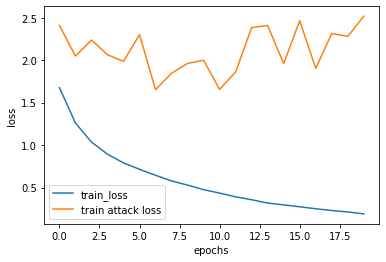

In [ ]:
train_loss_list
train_acc1_list 
val_acc_list
val_loss_list
train_acc2_list
import matplotlib.pyplot as plt
plt.plot(range(20), train_loss_list)
plt.plot(range(20), val_loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_loss', 'train attack loss'])

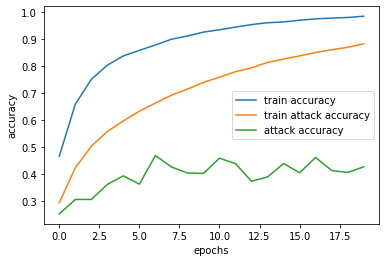

In [ ]:
plt.plot(range(20), train_acc1_list)
plt.plot(range(20), train_acc2_list)
plt.plot(range(20), val_acc_list)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train accuracy', 'train attack accuracy', 'attack accuracy'])

In [ ]:
accuracies = []
examples = []
epsilons = [.0005, .005, .05, .10]
table = []
# Run test for each epsilon
for eps in epsilons:
    acc, ex, pred = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)
    table.append(pred)

Epsilon: 0.0005	Test Accuracy = 6301 / 10000 = 0.6301
Epsilon: 0.005	Test Accuracy = 5388 / 10000 = 0.5388
Epsilon: 0.05	Test Accuracy = 2828 / 10000 = 0.2828
Epsilon: 0.1	Test Accuracy = 2294 / 10000 = 0.2294


In [ ]:
r1=[]
r2=[]
r3=[]
r4=[]
for i in table[0]:
  for j in i:
    r1.append(j)

for i in table[1]:
  for j in i:
    r2.append(j)

for i in table[2]:
  for j in i:
    r3.append(j)

for i in table[3]:
  for j in i:
    r4.append(j)

In [ ]:
r1 = np.array(r1)
r2 = np.array(r2)
r3 = np.array(r3)
np.sum(r1==r2), np.sum(r1==r3),np.sum(r1==r4),np.sum(r2==r3), np.sum(r2==r4), np.sum(r3==r4),

(7539, 5433, 3278, 6926, 3754, 4847)

In [ ]:
!cp '/content/Model_9' '/content/drive/My Drive/Colab Notebooks/adversarial'

In [ ]:
import numpy as np
a = [[1, 1, 0], [0, 1, 0], [0, 1, 1]]
a = np.array(a)
a

array([[1, 1, 0],
       [0, 1, 0],
       [0, 1, 1]])

In [ ]:
b = np.zeros_like(a)
def find(a, r, i, j):
  if i<0 or i>a.shape[0]-1 or j<0 or j>a.shape[1]-1:
    return
  if r!=[] and  r[-1]==[a.shape[0]-1, a.shape[1]-1]:
    return
  if not a[i, j]: return
  if a[i, j]:
    r.append([i, j])
  find(a, r, i+1, j)
  find(a, r, i, j+1)
  find(a, r, i-1, j)
  find(a, r, i, j-1)
b = []
find(a, b, 0, 0)
b

[[0, 0], [0, 1], [1, 1], [2, 1], [2, 2]]

In [ ]:
!git config — global user.email "21ssnxswz@gmail.com"
!git config — global user.name "hiden"